# Topic Modeling

Topic modeling experiments on TripAdvisor reviews. Dataset provided by the professor of 'CMP617 - Natural Language Processing and Information Recovery' at UFRGS.

## Setup
Installing and importing required libraries.

In [ ]:
%pip install bertopic sentence_transformers numpy pandas nltk gensim 'nbformat>=4.2.0' urllib3==1.26.15

from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt 
from bertopic import BERTopic
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from itertools import combinations
nltk.download('punkt')

## Dataset

Exploring the dataset. Getting the number of documents, the total number of characters, the document length distribution, etc.

In [4]:
DATASET_FILE = 'tripadvisor.csv'
df = pd.read_csv(DATASET_FILE)
df['len'] = df.text.str.len()

print(f'Documents: {len(df)}')
print(f'Dataset with review lengths from {df.len.min()} to {df.len.max()} characters.')
print(f'Total characters: {df.len.sum()}')
print(f'Total tokens: {df.tokens.sum()}')
df.head()

Documents: 9339
Dataset with review lengths from 44 to 602 characters.
Total characters: 2996292
Total tokens: 477367


,text,Rating,tokens,len
0,"hotel stayed hotel monaco cruise, rooms genero...",5,72,419
1,excellent stayed hotel monaco past w/e delight...,5,40,271
2,"poor value stayed monaco seattle july, nice ho...",2,55,333
3,nice value seattle stayed 4 nights late 2007. ...,4,56,364
4,nice hotel not nice staff hotel lovely staff q...,3,78,417


Text(0, 0.5, 'No of documents')

<Figure size 640x480 with 0 Axes>

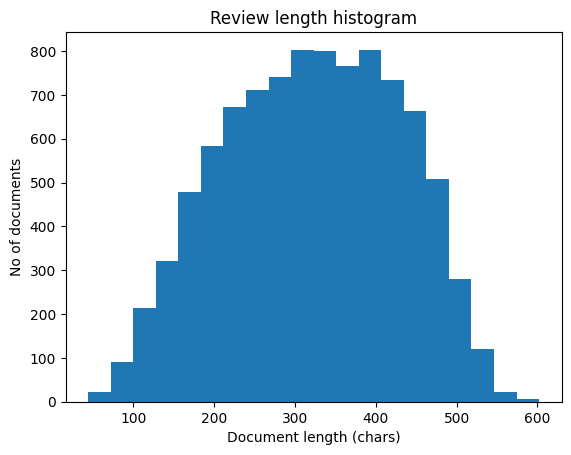

In [9]:
plt.figure()
df.hist('len', grid=False, bins=20)
plt.title('Review length histogram')
plt.xlabel('Document length (chars)')
plt.ylabel('No of documents')

Text(0, 0.5, 'No of documents')

<Figure size 640x480 with 0 Axes>

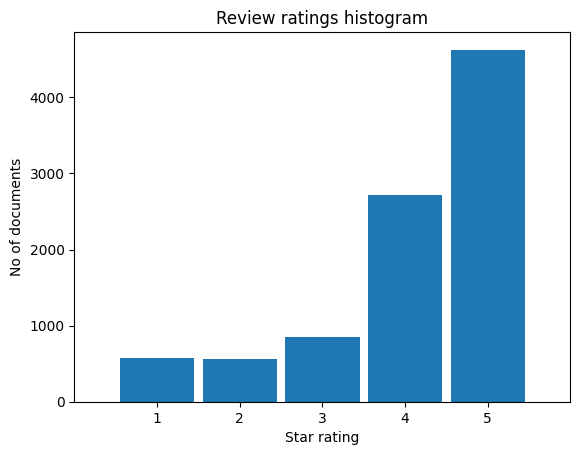

In [10]:
import matplotlib.pyplot as plt 
plt.figure()
df.hist('Rating', grid=False, bins=np.arange(7)-0.5, rwidth=0.9)
plt.title('Review ratings histogram')
plt.xlabel('Star rating')
plt.xticks(range(1,6))
plt.xlim([0, 6])
plt.ylabel('No of documents')

Text(0, 0.5, 'Document length')

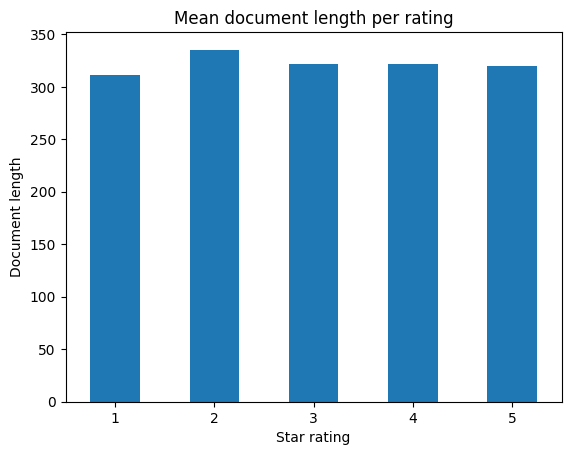

In [11]:
plt.figure()
df.groupby('Rating').len.mean().plot.bar()
plt.title('Mean document length per rating')
plt.xlabel('Star rating')
plt.xticks(rotation=0)
plt.ylabel('Document length')

We see that although most documents have 5 star ratings, the average document length per category is similar.

This makes sense, since, per the review length histogram, most reviews have lengths ranging from 250 to 450 characters.

## Embeddings
Generating embeddings from the document. Options to save them to disk and import them later.

In [ ]:
sentence_model = SentenceTransformer('all-mpnet-base-v2', device='cpu')
embeddings = sentence_model.encode(df.text, device='cpu', show_progress_bar=True)
embeddings.shape

Saving the embeddings to avoid having to re-run the enconding again every time the kernel is restarted.

In [ ]:
with open('./embeddings.npy', 'wb') as f:
    np.save(f, embeddings, allow_pickle=True)

(9339, 768)

In [2]:
embeddings = np.load('./embeddings.npy', allow_pickle=True)
embeddings.shape

(9339, 768)

## BERTopic
Standard BERTopic implementation to get a general feel for the available topics in the documents.

In [5]:
topic_model = BERTopic()
topics, _ = topic_model.fit_transform(df.text, embeddings=embeddings)
print(f'Total number of topics: {len(topics)}')
print(f'Number of unique topics: {len(set(topics))}')
topic_model.get_topic_info().head()
topic_model.visualize_barchart(top_n_topics=10, n_words=8)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Total number of topics: 9339
Number of unique topics: 83


### N-grams
We can see that a lot of the topics contain words that are part of a multi-word proper noun (e.g.: Topic 7 top words are 'san' and 'fracisco', for the city 'San Fracisco; Topic 6 similarly  'new' and 'york' for 'New York'). Thus, I will try to model again using unigrams and bigrams. 

In [14]:
topic_model = BERTopic(n_gram_range=(1, 2)).fit(df.text, embeddings=embeddings)
print(f'Total number of topics: {len(topic_model.topics_)}')
print(f'Number of unique topics: {len(set(topic_model.topics_))}')
topic_model.get_topic_info().head()
topic_model.visualize_barchart(top_n_topics=10, n_words=8)

Total number of topics: 9339
Number of unique topics: 82


## Clustering
Trying out two clustering algorithms (HDBSCAN and K-means) to check their impact on the found topics.

### HDBSCAN

In [13]:
hdbscan_model = HDBSCAN(min_cluster_size=50, cluster_selection_method='eom', prediction_data=True)
hdbscan_topic_model = BERTopic(hdbscan_model=hdbscan_model).fit(df.text, embeddings=embeddings)
print(f'Total number of topics: {len(hdbscan_topic_model.topics_)}')
print(f'Number of unique topics: {len(set(hdbscan_topic_model.topics_))}')
hdbscan_topic_model.get_topic_info().head()
hdbscan_topic_model.visualize_barchart(top_n_topics=10, n_words=8)

Total number of topics: 9339
Number of unique topics: 24


### K-Means


In [12]:
kmeans_model = KMeans(n_clusters=15)
kmeans_topic_model = BERTopic(hdbscan_model=kmeans_model).fit(df.text, embeddings=embeddings)
print(f'Total number of topics: {len(kmeans_topic_model.topics_)}')
print(f'Number of unique topics: {len(set(kmeans_topic_model.topics_))}')
kmeans_topic_model.get_topic_info().head()
kmeans_topic_model.visualize_barchart(top_n_topics=10, n_words=8)

Total number of topics: 9339
Number of unique topics: 15


## Metrics
Calculating coherence and diversity for topic modeling with each clustering algorithm. 

### Coherence


In [19]:
def coherence_score(docs, topic_model, coherence_type='c_v'):
    # https://github.com/MaartenGr/BERTopic/issues/90#issuecomment-1455027341
    # Preprocess Documents
    topics = topic_model.topics_
    documents = pd.DataFrame({"Document": docs,
                            "ID": range(len(docs)),
                            "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Use .get_feature_names_out() if you get an error with .get_feature_names()
    words = vectorizer.get_feature_names_out()

    # Extract features for Topic Coherence evaluation
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]

    # Extract words in each topic if they are non-empty and exist in the dictionary
    topic_words = []
    for topic in range(len(set(topics))-topic_model._outliers):
        words = list(zip(*topic_model.get_topic(topic)))[0]
        words = [word for word in words if word in dictionary.token2id]
        topic_words.append(words)
    topic_words = [words for words in topic_words if len(words) > 0]

    # Evaluate Coherence
    coherence_model = CoherenceModel(topics=topic_words,
                                    texts=tokens,
                                    corpus=corpus,
                                    dictionary=dictionary,
                                    coherence=coherence_type)
    coherence = coherence_model.get_coherence()
    return coherence

kmeans_coherence = coherence_score(df.text, kmeans_topic_model)
hdbscan_coherence = coherence_score(df.text, hdbscan_topic_model)
print(f'Coherence score... K-means: {kmeans_coherence:.4f} | HDBSCAN: {hdbscan_coherence:.4f}')

Coherence score... K-means: 0.4191 | HDBSCAN: 0.4543


### Diversity


In [22]:
def proportion_unique_words(topics, topk=10):
    #https://github.com/silviatti/topic-model-diversity/blob/master/README.md
    if topk > len(topics[0]):
        raise Exception('Words in topics are less than '+str(topk))
    else:
        unique_words = set()
        for topic in topics:
            unique_words = unique_words.union(set(topic[:topk]))
        puw = len(unique_words) / (topk * len(topics))
        return puw


def pairwise_jaccard_diversity(topics, topk=10):
    #https://github.com/silviatti/topic-model-diversity/blob/master/README.md
    dist = 0
    count = 0
    for list1, list2 in combinations(topics, 2):
        js = 1 - len(set(list1).intersection(set(list2)))/len(set(list1).union(set(list2)))
        dist = dist + js
        count = count + 1
    return dist/count

kmeans_topics_lists = list(kmeans_topic_model.get_topic_info()['Representation'])
hdbscan_topics_lists = list(hdbscan_topic_model.get_topic_info()['Representation'])

kmeans_puw = proportion_unique_words(kmeans_topics_lists, topk=10)
hdbscan_puw = proportion_unique_words(hdbscan_topics_lists, topk=10)

kmeans_jaccard = pairwise_jaccard_diversity(kmeans_topics_lists, topk=10)
hdbscan_jaccard = pairwise_jaccard_diversity(hdbscan_topics_lists, topk=10)

print(f'Proportion of unique words... K-means: {kmeans_puw:.4f} | HDBSCAN: {hdbscan_puw:.4f}')
print(f'Jaccard diversity... K-means: {kmeans_jaccard:.4f} | HDBSCAN: {hdbscan_jaccard:.4f}')

Proportion of unique words... K-means: 0.4267 | HDBSCAN: 0.4208
Jaccard diversity... K-means: 0.7083 | HDBSCAN: 0.7658
